# Topic Modeling

Akio Kakishima

### Sources

https://radimrehurek.com/gensim/models/ldaseqmodel.html

https://markroxor.github.io/gensim/static/notebooks/ldaseqmodel.html

https://www.youtube.com/watch?v=7BMsuyBPx90 <-- Dave Blei's Google talk on Dynamic Topic Modelling

https://towardsdatascience.com/exploring-the-un-general-debates-with-dynamic-topic-models-72dc0e307696 

^ Explains why each new paragraph should be treated as a separate document in DTM


### Notes
This .ipynb file runs topic modeling. Make sure to have parsed the PDFs before running this analysis. 

In [1]:
BIGRAMS = False
LOAD_DICTIONARY = True
LOAD_LDA = True
LOAD_DTM = True
num_topics = 5

In [2]:
from collections import Counter
from gensim import models
from gensim.corpora import Dictionary, bleicorpus
from gensim.models import ldaseqmodel, ldamodel
from gensim.models.wrappers.dtmmodel import DtmModel
from gensim.test.utils import datapath
# import pyLDAvis
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer 
import numpy as np
import os
import pandas as pd # ver 0.24.2
import pickle
import re
import time
import winsound

In [3]:
def preprocess(raw, BIGRAM):
    """
    Takes in a string, lowercases all the text,
    fixes hyphenation, then tokenizes the input. 
    Outputs a list of all the tokens in the input document. 
    Each token is at least 3 chars long. 
    Also removed numbers, and stopwords. 
    Stopwords downloaded from nltk.downloads('stopwords'). 

    Parameters
    ----------
    first : string, or parser 
        `raw` is the pdf document

    Returns
    -------
    list
        A list of each token, stopword filtered

    """

    lowered = raw.lower()
    fixed = re.sub(r'[\-]\W+', '', lowered)
    whitespace = re.sub(r'[\W]+', ' ', fixed)

    tokenizer = RegexpTokenizer(r'[A-z]{4,}')
    additional_list = ['also', 'ndr', 'red', 'crescent', 'cross', 'world', 'disaster', 'report', 'chap', 'page']
    tokenized = [word for word in tokenizer.tokenize(fixed) if word not in additional_list]
    
    lemmatizer = WordNetLemmatizer()
    lemmed = [lemmatizer.lemmatize(word) for word in tokenized if word not in stopwords.words('english')]

    if BIGRAM:
        bigram = list(nltk.bigrams(lemmed))
        filtered_words = [i for i in map('_'.join, bigram)]
    else:
        filtered_words = lemmed
    
    return filtered_words

In [4]:
def extract_para(raw, len_list):
    """
    Input is lowercased, and split by paragraph breaks
    using regex. The number of paragraphs are analyzed
    and appended in input list, 'len_list'
    
    Returns a list, 'list_of_paragraphs', which is the
    output from the split function.

    Parameters
    ----------
    first : string
        text of the PDF file
    second : list
        list to keep track of number of paragraph 
        extracted from input, 'raw'
        
    Returns
    -------
    list

    """

    lowered = raw.lower()
    list_of_paragraphs = re.split(r'\.[ ][\n]+', lowered)
    len_list.append(len(list_of_paragraphs))
    
    return list_of_paragraphs

In [5]:
def determine_year(pdf_title):
    searchObj = re.search(r'20[0-9]{2}|19[0-9]{2}', pdf_title, re.M|re.I)
    if searchObj:
        year = searchObj.group()
    
    return int(year)

In [6]:
def beeper():
    '''
    Beeps when activated
    '''
    
    eighth = 250
    half = 1000
    g = 392 #hz
    ef = 311 #hz

    for i in range(3):
        winsound.Beep(g, eighth)
    winsound.Beep(ef, half)

## Get/Set common_corpus and common_dictionary

In [7]:
%%time

if LOAD_DICTIONARY:
    print("loading Dictionary, corpus, and len documents")
    common_dictionary = Dictionary.load('model/common_dictionary')
    with open('model/common_corpus_pickled', 'rb') as f:
        common_corpus = pickle.load(f)
    with open('model/len_docs_pickled', 'rb') as f:
        lengths_of_docs = pickle.load(f)
    
else:
    print("Dictionary, corpus, and len documents not found; initializing")

    text_library = {}
    list_of_string = []
    list_of_list_of_string = []
    lengths_of_docs = []

    path = "data/"
    dirs = os.listdir(path)
    for each_pdf in dirs:
        if each_pdf == 'WDR-2018-EN-LR.pdf': pass # our testset
        else:
            print(each_pdf)       
            with open('txt/{}.txt'.format(str(each_pdf)), 'r', encoding='utf8') as f:
                text = f.read()
                text_year = determine_year(each_pdf)
                try:
                    text_update = "{}\n{}".format(text_library[text_year], text)
                    text_library.update({text_year: text_update})
                except:
                    text_library[text_year] = text

    for i in sorted(text_library):
        print("year: {}".format(i))
        text = text_library[i]
        list_of_paragraphs = extract_para(text, lengths_of_docs)
        for i in list_of_paragraphs:
            if len(i) > 3:
                list_of_list_of_string.append(preprocess(i, BIGRAMS))
            else: pass

    # Create a corpus from a list of texts
    common_dictionary = Dictionary(list_of_list_of_string)
    common_corpus = [common_dictionary.doc2bow(text) for text in list_of_list_of_string]

    common_dictionary.save('model/common_dictionary')
    with open('model/common_corpus_pickled', 'wb') as f:
        pickle.dump(common_corpus, f)
    with open('model/len_docs_pickled', 'wb') as f:
        pickle.dump(lengths_of_docs, f)

loading Dictionary, corpus, and len documents
Wall time: 60.2 ms


In [ ]:
[print(i) for i in common_dictionary.values() if len(i) < 4]

## NMF

In [ ]:
# nmf = models.Nmf(common_corpus, num_topics=10)

## Baseline: LDA

In [8]:
%%time
home = os.getcwd()

if LOAD_LDA:
    print("loading LDAmodel")
    lda = ldamodel.LdaModel.load(os.path.join(home, 'model/LDAmodel_{}'.format(num_topics)))
else:
    for num_topics_sub in [5,10,15]:
        print("LDAmodel not found; initializing ldamodel")
        lda = ldamodel.LdaModel(corpus=common_corpus, id2word=common_dictionary, num_topics=num_topics_sub, update_every=1, passes=1)

        print("saving")
        lda.save(os.path.join(home, 'model/LDAmodel_{}'.format(num_topics_sub)))

loading LDAmodel
Wall time: 17 ms


In [32]:
def pretty_print_topic(n_w = len(common_dictionary.values())):
    epoch = []
    topic_list = []
    topic_imp = []
    
    for idx, each_topic in enumerate(lda.print_topics(num_topics=num_topics, num_words=n_w)):
        # len(common_dictionary.values()) = gets all vocab
        for each_token in each_topic[1].split('+'):
            topic_importance, token = each_token.split("*")
            topic_list.append(re.sub(r'[^A-z0-9]+', '', token))
            topic_imp.append(topic_importance)
            epoch.append(idx)
    data = {'epoch': epoch, 'topic': topic_list, 'topic_importance': topic_imp}
    lda_df = pd.DataFrame.from_dict(data)
#     print(len(lda_df))
#     display(lda_df)
    
    return lda_df

lda_df = pretty_print_topic(n_w = 5)

for each_epoch in lda_df['epoch'].unique():
    display(lda_df[lda_df['epoch'] == each_epoch]['topic'])

0         million
1    humanitarian
2            data
3          people
4         country
Name: topic, dtype: object

5           people
6     humanitarian
7             risk
8    international
9        community
Name: topic, dtype: object

10        community
11           people
12     humanitarian
13    international
14             year
Name: topic, dtype: object

15    refugee
16      unhcr
17    country
18     people
19     asylum
Name: topic, dtype: object

20    humanitarian
21       available
22          online
23        disaster
24            data
Name: topic, dtype: object

## DTM

In [9]:
%%time
home = os.getcwd()

if LOAD_DTM:
    print("loading DTMmodel")
    ldaseq = ldaseqmodel.LdaSeqModel.load('model/DTMmodel_{}'.format(num_topics))
else:
    for num_topics_sub in [5]:
        print("DTMmodel not found; initializing DTMmodel")
        bc = bleicorpus.BleiCorpus.serialize(fname=os.path.join(home, 'model/blei_{}'.format(num_topics_sub)), corpus=common_corpus)
        ldaseq = ldaseqmodel.LdaSeqModel(corpus=common_corpus, id2word=common_dictionary, time_slice=lengths_of_docs, num_topics=num_topics_sub)
        # ldaseq.print_topics(time=0)

        print("saving")
        ldaseq.save(os.path.join(home, 'model/DTMmodel_{}'.format(num_topics_sub)))

loading DTMmodel
Wall time: 541 ms


In [10]:
def output_dtm(as_csv = False):
    '''
    Saves output of DTM as csv
    '''
    if as_csv:
        with open('dtm_output.csv', 'w', newline='') as f:
            csv_writer = csv.writer(f)
            csv_writer.writerow(['topic', 'time', 'term', 'topic_importance'])
            for t in range(len(lengths_of_docs)):
                counter = 0
                for i in ldaseq.print_topics(time=t, top_terms=15):
            #         print(i)
                    counter += 1
                    for j in range(len(i)):
                        csv_writer.writerow([counter,t,i[j][0], i[j][1]])
    else:
        pandas_dict = {}
        counter = 0
        for each_epoch in range(len(lengths_of_docs)):
            for each_topic, i in enumerate(ldaseq.print_topics(time=each_epoch, top_terms=len(common_dictionary.values()))):
                for each_tuple in i:
                    (term, importance) = each_tuple
                    pandas_dict.update({counter: [each_epoch, each_topic, term, importance]})
                    counter += 1
        output_df = pd.DataFrame.from_dict(pandas_dict, orient='index', columns=['epoch', 'topic_number', 'topic_terms', 'topic_importance'])
        return output_df
dtm_df = output_dtm()
dtm_df['id']= dtm_df['topic_terms'].map(common_dictionary.token2id)
dtm_df.head()

,epoch,topic_number,topic_terms,topic_importance,id
0,0,0,refugee,0.044176,215
1,0,0,data,0.037131,366
2,0,0,country,0.034227,116
3,0,0,people,0.026282,48
4,0,0,figure,0.025451,408


In [11]:
def display_viz(save = True, time = 0):
    doc_topic, topic_term, doc_lengths, term_frequency, vocab = ldaseq.dtm_vis(time=time, corpus = common_corpus)
    vis_wrapper = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
    if save:
        pyLDAvis.save_html(vis_wrapper, 'viz/DTM{}_viz.html'.format(num_topics))
    else: pass
    return pyLDAvis.display(vis_wrapper)

In [20]:
display_viz(time=0)

C:\Users\akiok\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


lambda = 1 results in the familiar ranking of terms in decreasing order of their topic-specific probability, and setting lambda = 0 ranks terms solely by their lift

lift: the ratio of a term’s probability within a topic to its marginal probability across the corpus.

# Predict distributions

In [19]:
common_dictionary.token2id

{'acknow': 0,
 'activity': 1,
 'alleviate': 2,
 'among': 3,
 'analysis': 4,
 'annually': 5,
 'brings': 6,
 'case': 7,
 'cause': 8,
 'center': 9,
 'committee': 10,
 'constitute': 11,
 'contribution': 12,
 'control': 13,
 'coordinating': 14,
 'crisis': 15,
 'detailed': 16,
 'development': 17,
 'difference': 18,
 'disaster': 19,
 'disease': 20,
 'effect': 21,
 'emergency': 22,
 'encouraging': 23,
 'eric': 24,
 'evergrowing': 25,
 'extraordinary': 26,
 'face': 27,
 'fact': 28,
 'federation': 29,
 'field': 30,
 'focus': 31,
 'health': 32,
 'human': 33,
 'humanitarian': 34,
 'indispensable': 35,
 'infectious': 36,
 'information': 37,
 'international': 38,
 'intervention': 39,
 'latest': 40,
 'make': 41,
 'management': 42,
 'movement': 43,
 'multiply': 44,
 'national': 45,
 'noji': 46,
 'partnership': 47,
 'people': 48,
 'preparedness': 49,
 'prevent': 50,
 'prevention': 51,
 'price': 52,
 'promotes': 53,
 'provocative': 54,
 'public': 55,
 'published': 56,
 'recommended': 57,
 'reference': 5

In [18]:
[print(i) for i in common_dictionary.items()]

(0, 'acknow')
(1, 'activity')
(2, 'alleviate')
(3, 'among')
(4, 'analysis')
(5, 'annually')
(6, 'brings')
(7, 'case')
(8, 'cause')
(9, 'center')
(10, 'committee')
(11, 'constitute')
(12, 'contribution')
(13, 'control')
(14, 'coordinating')
(15, 'crisis')
(16, 'detailed')
(17, 'development')
(18, 'difference')
(19, 'disaster')
(20, 'disease')
(21, 'effect')
(22, 'emergency')
(23, 'encouraging')
(24, 'eric')
(25, 'evergrowing')
(26, 'extraordinary')
(27, 'face')
(28, 'fact')
(29, 'federation')
(30, 'field')
(31, 'focus')
(32, 'health')
(33, 'human')
(34, 'humanitarian')
(35, 'indispensable')
(36, 'infectious')
(37, 'information')
(38, 'international')
(39, 'intervention')
(40, 'latest')
(41, 'make')
(42, 'management')
(43, 'movement')
(44, 'multiply')
(45, 'national')
(46, 'noji')
(47, 'partnership')
(48, 'people')
(49, 'preparedness')
(50, 'prevent')
(51, 'prevention')
(52, 'price')
(53, 'promotes')
(54, 'provocative')
(55, 'public')
(56, 'published')
(57, 'recommended')
(58, 'reference

(1754, 'swamping')
(1755, 'tidal')
(1756, 'tube')
(1757, 'animal')
(1758, 'coconut')
(1759, 'corps')
(1760, 'good')
(1761, 'green')
(1762, 'hazard')
(1763, 'littering')
(1764, 'materialized')
(1765, 'nutrient')
(1766, 'predicted')
(1767, 'thought')
(1768, 'valuable')
(1769, 'awareness')
(1770, 'boil')
(1771, 'comprehension')
(1772, 'consumption')
(1773, 'hygiene')
(1774, 'knew')
(1775, 'mobile')
(1776, 'presence')
(1777, 'reinforced')
(1778, 'admission')
(1779, 'bigger')
(1780, 'borne')
(1781, 'certainly')
(1782, 'chemical')
(1783, 'communicable')
(1784, 'considered')
(1785, 'cuttack')
(1786, 'distributed')
(1787, 'halogen')
(1788, 'incidence')
(1789, 'integral')
(1790, 'occurred')
(1791, 'overcrowded')
(1792, 'paradwip')
(1793, 'rapid')
(1794, 'tablet')
(1795, 'undertaken')
(1796, 'unsanitary')
(1797, 'becomes')
(1798, 'fifth')
(1799, 'fragile')
(1800, 'impact')
(1801, 'sell')
(1802, 'serious')
(1803, 'starvation')
(1804, 'survive')
(1805, 'acted')
(1806, 'alleges')
(1807, 'belarusian

(3254, 'performance')
(3255, 'practise')
(3256, 'practising')
(3257, 'prefers')
(3258, 'preliminary')
(3259, 'real')
(3260, 'relationship')
(3261, 'renewed')
(3262, 'respectable')
(3263, 'stage')
(3264, 'statement')
(3265, 'stringent')
(3266, 'vaccinate')
(3267, 'warring')
(3268, 'calm')
(3269, 'career')
(3270, 'dominated')
(3271, 'dwindling')
(3272, 'introduce')
(3273, 'overwhelming')
(3274, 'pervading')
(3275, 'reflection')
(3276, 'rivalry')
(3277, 'turnover')
(3278, 'discus')
(3279, 'learning')
(3280, 'lectureship')
(3281, 'maximize')
(3282, 'prepared')
(3283, 'reflective')
(3284, 'replicated')
(3285, 'stimulating')
(3286, 'debate')
(3287, 'documenting')
(3288, 'dominate')
(3289, 'facilitating')
(3290, 'fail')
(3291, 'formally')
(3292, 'intends')
(3293, 'refinement')
(3294, 'tend')
(3295, 'wrap')
(3296, 'writing')
(3297, 'philanthropist')
(3298, 'strategic')
(3299, 'vaccinated')
(3300, 'always')
(3301, 'build')
(3302, 'contributes')
(3303, 'impression')
(3304, 'inactivity')
(3305, '

(4753, 'noticed')
(4754, 'openness')
(4755, 'understood')
(4756, 'welltrained')
(4757, 'woven')
(4758, 'appointed')
(4759, 'cement')
(4760, 'cloth')
(4761, 'dprkrc')
(4762, 'jrcs')
(4763, 'repatriation')
(4764, 'residing')
(4765, 'rokrc')
(4766, 'round')
(4767, 'sends')
(4768, 'seoul')
(4769, 'successor')
(4770, 'agrees')
(4771, 'construction')
(4772, 'diminishing')
(4773, 'dong')
(4774, 'fire')
(4775, 'fly')
(4776, 'forget')
(4777, 'heart')
(4778, 'hit')
(4779, 'inspect')
(4780, 'inspection')
(4781, 'interfere')
(4782, 'kedo')
(4783, 'peninsula')
(4784, 'reduces')
(4785, 'respectively')
(4786, 'responsible')
(4787, 'taepo')
(4788, 'undated')
(4789, 'undeclared')
(4790, 'underground')
(4791, 'withdraws')
(4792, 'proposed')
(4793, 'track')
(4794, 'advisory')
(4795, 'exceed')
(4796, 'establishes')
(4797, 'italy')
(4798, 'adelphi')
(4799, 'aiden')
(4800, 'array')
(4801, 'article')
(4802, 'book')
(4803, 'button')
(4804, 'carter')
(4805, 'comm')
(4806, 'curie')
(4807, 'dublin')
(4808, 'edge

(6253, 'reminiscent')
(6254, 'sovereign')
(6255, 'spate')
(6256, 'sponsored')
(6257, 'charter')
(6258, 'jurisdiction')
(6259, 'latter')
(6260, 'preconflict')
(6261, 'underscored')
(6262, 'aggression')
(6263, 'authorize')
(6264, 'breach')
(6265, 'accepts')
(6266, 'assertive')
(6267, 'eclipsed')
(6268, 'premise')
(6269, 'arbitrarily')
(6270, 'covenant')
(6271, 'discount')
(6272, 'explicitly')
(6273, 'immigration')
(6274, 'liberty')
(6275, 'lightly')
(6276, 'quarantine')
(6277, 'reasonable')
(6278, 'respected')
(6279, 'scrutiny')
(6280, 'sentence')
(6281, 'shall')
(6282, 'shoulder')
(6283, 'submit')
(6284, 'judgement')
(6285, 'obstructed')
(6286, 'presently')
(6287, 'draft')
(6288, 'exert')
(6289, 'expediting')
(6290, 'milestone')
(6291, 'teeth')
(6292, 'treatise')
(6293, 'undertook')
(6294, 'unitar')
(6295, 'administrative')
(6296, 'attending')
(6297, 'envisioned')
(6298, 'functional')
(6299, 'idndr')
(6300, 'mundane')
(6301, 'parliamentary')
(6302, 'visionary')
(6303, 'privilege')
(6304

(7752, 'fabian')
(7753, 'fedcross')
(7754, 'fedecr')
(7755, 'fedecruz')
(7756, 'florencia')
(7757, 'friendship')
(7758, 'gamhouria')
(7759, 'gevorg')
(7760, 'gharani')
(7761, 'golfe')
(7762, 'gomb')
(7763, 'grey')
(7764, 'hassan')
(7765, 'hauz')
(7766, 'helai')
(7767, 'herois')
(7768, 'hostility')
(7769, 'ifrc_sar')
(7770, 'ifrcaf')
(7771, 'ifrcao')
(7772, 'ifrcar')
(7773, 'ifrcbd')
(7774, 'ifrcby')
(7775, 'ifrccm')
(7776, 'ifrcdsb')
(7777, 'ifrcet')
(7778, 'ifrcge')
(7779, 'ifrcin')
(7780, 'ifrcke')
(7781, 'ifrckh')
(7782, 'ifrckz')
(7783, 'ifrcmk')
(7784, 'ifrcmy')
(7785, 'ifrcmz')
(7786, 'ifrcpg')
(7787, 'ifrcrds')
(7788, 'ifrcrw')
(7789, 'ifrcsd')
(7790, 'ifrctm')
(7791, 'ifrctz')
(7792, 'ifrcua')
(7793, 'ifrcuz')
(7794, 'ifrcven')
(7795, 'ifrczm')
(7796, 'ifrczw')
(7797, 'illustrated')
(7798, 'immeuble')
(7799, 'imul')
(7800, 'indexed')
(7801, 'inforboard')
(7802, 'infoweb')
(7803, 'interdisciplinary')
(7804, 'irfca')
(7805, 'jamal')
(7806, 'katalikosi')
(7807, 'kelemu')
(7808, 'k

(9252, 'straining')
(9253, 'suited')
(9254, 'supervise')
(9255, 'assassination')
(9256, 'careful')
(9257, 'debacle')
(9258, 'deter')
(9259, 'detract')
(9260, 'fade')
(9261, 'grafted')
(9262, 'initiating')
(9263, 'instructive')
(9264, 'kidnapping')
(9265, 'negate')
(9266, 'offensive')
(9267, 'procrastination')
(9268, 'striving')
(9269, 'unimportance')
(9270, 'judiciary')
(9271, 'alter')
(9272, 'borrowing')
(9273, 'cultivated')
(9274, 'customer')
(9275, 'depriving')
(9276, 'diaspora')
(9277, 'emergence')
(9278, 'ethnically')
(9279, 'exploit')
(9280, 'hazardous')
(9281, 'homogenous')
(9282, 'hutu')
(9283, 'inception')
(9284, 'indepth')
(9285, 'inequitable')
(9286, 'moderate')
(9287, 'nepotism')
(9288, 'remittance')
(9289, 'seized')
(9290, 'seizure')
(9291, 'tutsi')
(9292, 'undertaking')
(9293, 'unregulated')
(9294, 'validation')
(9295, 'conducting')
(9296, 'rubella')
(9297, 'usage')
(9298, 'minimized')
(9299, 'relating')
(9300, 'determines')
(9301, 'regulated')
(9302, 'blatantly')
(9303, 

(10751, 'altruism')
(10752, 'deity')
(10753, 'derive')
(10754, 'inspires')
(10755, 'movement]')
(10756, 'philosopher')
(10757, 'pride')
(10758, 'reciprocity')
(10759, 'spiritual')
(10760, 'squad')
(10761, 'taylor')
(10762, 'amateur')
(10763, 'bangladesh]')
(10764, 'bell')
(10765, 'benevolence')
(10766, 'deserving')
(10767, 'judgemental')
(10768, 'patronizing')
(10769, 'peppiatt')
(10770, 'prevails')
(10771, 'putnam')
(10772, 'transformed')
(10773, 'victorian')
(10774, 'empowered')
(10775, 'wilmer')
(10776, 'response]')
(10777, 'implicit')
(10778, 'adherent')
(10779, 'choosing')
(10780, 'cohort')
(10781, 'dreamed')
(10782, 'founder')
(10783, 'practised')
(10784, 'thoroughly')
(10785, 'zealous')
(10786, 'renewing')
(10787, 'astrid')
(10788, 'heiberg')
(10789, 'justin')
(10790, 'monolithic')
(10791, 'voluntarily')
(10792, 'anheier')
(10793, 'chorus')
(10794, 'helmut')
(10795, 'lester')
(10796, 'milligan')
(10797, 'reminded')
(10798, 'salamon')
(10799, 'blacksell')
(10800, 'energize')
(108

(12251, 'drugdependency')
(12252, 'dumping')
(12253, 'econ')
(12254, 'eddie')
(12255, 'efqm')
(12256, 'elect')
(12257, 'elia')
(12258, 'embarking')
(12259, 'eminent')
(12260, 'emotional')
(12261, 'enablers')
(12262, 'endorsement')
(12263, 'engine')
(12264, 'entailed')
(12265, 'erupted')
(12266, 'escalating')
(12267, 'escalation')
(12268, 'essence')
(12269, 'evaluating')
(12270, 'evolution')
(12271, 'excellence')
(12272, 'exchanging')
(12273, 'excluded')
(12274, 'exercising')
(12275, 'exhausting')
(12276, 'exploiter')
(12277, 'extract')
(12278, 'extracting')
(12279, 'fabricated')
(12280, 'fayez')
(12281, 'finalized')
(12282, 'finger')
(12283, 'flux')
(12284, 'founding')
(12285, 'fragment')
(12286, 'freshly')
(12287, 'frivolous')
(12288, 'frustrating')
(12289, 'fulfilment')
(12290, 'gatorade')
(12291, 'geoffroy')
(12292, 'geohaz')
(12293, 'ghafer')
(12294, 'gilgalramallah')
(12295, 'graham')
(12296, 'grounded')
(12297, 'hadera')
(12298, 'haifa')
(12299, 'halting')
(12300, 'hamed')
(12301

(13750, 'supervisor')
(13751, 'sweatshop')
(13752, 'temple')
(13753, 'terrorize')
(13754, 'thrusted')
(13755, 'trafficker')
(13756, 'transcontinental')
(13757, 'undergo')
(13758, 'undernourished')
(13759, 'unintentionally')
(13760, 'ventilation')
(13761, 'workplace')
(13762, 'baked')
(13763, 'chinameca')
(13764, 'delicacy')
(13765, 'dissatisfied')
(13766, 'excerpt')
(13767, 'laundry')
(13768, 'malian')
(13769, 'marena')
(13770, 'originating')
(13771, 'restrictive')
(13772, 'salon')
(13773, 'soliciting')
(13774, 'thankful')
(13775, 'visa')
(13776, 'anima')
(13777, 'california')
(13778, 'demining')
(13779, 'duran')
(13780, 'elena')
(13781, 'emphasizing')
(13782, 'generalized')
(13783, 'illinois')
(13784, 'raffle')
(13785, 'reintegrate')
(13786, 'remitted')
(13787, 'zacatecanos')
(13788, 'zacatecas')
(13789, 'marsh')
(13790, 'regrouped')
(13791, 'regroupment')
(13792, 'victimized')
(13793, 'wandered')
(13794, 'accomplishing')
(13795, 'affluent')
(13796, 'alien')
(13797, 'applicant')
(1379

(15250, 'misdemeanour')
(15251, 'savagely')
(15252, 'vented')
(15253, 'blighting')
(15254, 'catalogued')
(15255, 'coerced')
(15256, 'condemns')
(15257, 'cruelty')
(15258, 'toil')
(15259, 'agonizingly')
(15260, 'chitungwiza')
(15261, 'copper')
(15262, 'spiwa')
(15263, 'tochild')
(15264, 'auntie')
(15265, 'caller')
(15266, 'dissolve')
(15267, 'distracts')
(15268, 'florence')
(15269, 'harming')
(15270, 'homecare')
(15271, 'lagging')
(15272, 'mutukwa')
(15273, 'ottile')
(15274, 'outpaced')
(15275, 'slide')
(15276, 'uncharted')
(15277, 'appalled')
(15278, 'decoration')
(15279, 'ointment')
(15280, 'sore')
(15281, 'sputum')
(15282, 'taped')
(15283, 'underfunding')
(15284, 'interacting')
(15285, 'tumushabe')
(15286, 'apocalypse')
(15287, 'blewitt')
(15288, 'corrosion')
(15289, 'fattened')
(15290, 'khanya')
(15291, 'mabuza')
(15292, 'meat')
(15293, 'middleman')
(15294, 'pittance')
(15295, 'revolve')
(15296, 'unacknowledged')
(15297, 'unstoppable')
(15298, 'ailing')
(15299, 'belita')
(15300, 'di

(16749, 'fame')
(16750, 'gilligan')
(16751, 'impulse')
(16752, 'inch')
(16753, 'jack')
(16754, 'mirren')
(16755, 'nose')
(16756, 'overstressed')
(16757, 'pigheadedness')
(16758, 'quasi')
(16759, 'raced')
(16760, 'slave')
(16761, 'spotlighted')
(16762, 'superlative')
(16763, 'airwave')
(16764, 'graft')
(16765, 'junior')
(16766, 'sifting')
(16767, 'media]')
(16768, 'paperwork')
(16769, 'barrow')
(16770, 'slows')
(16771, 'audio')
(16772, 'bogert')
(16773, 'bosnian')
(16774, 'carroll')
(16775, 'cautiously')
(16776, 'chronicle')
(16777, 'dick')
(16778, 'emily')
(16779, 'irretrievably')
(16780, 'listservs')
(16781, 'mujawayo')
(16782, 'newsgroups')
(16783, 'nyarabuye')
(16784, 'plea')
(16785, 'slumber')
(16786, 'worded')
(16787, 'yardstick')
(16788, 'adrian')
(16789, 'belied')
(16790, 'compression')
(16791, 'feedpoint')
(16792, 'mcintyre')
(16793, 'psychotherapist')
(16794, 'robbery')
(16795, 'trek')
(16796, 'agile')
(16797, 'dithering')
(16798, 'finer')
(16799, 'olav')
(16800, 'saltbones')


(18249, 'otitoyomi')
(18250, 'palmas')
(18251, '[likewise')
(18252, 'credence')
(18253, 'delincuentes')
(18254, 'frica')
(18255, 'jumpingoff')
(18256, 'stemming')
(18257, '[but]')
(18258, '[legal]')
(18259, 'abhorrent')
(18260, 'accession')
(18261, 'amendment')
(18262, 'arbor')
(18263, 'arguable')
(18264, 'arne')
(18265, 'asentamientos')
(18266, 'asylumprocessing')
(18267, 'attachements')
(18268, 'baldwin')
(18269, 'barcelona')
(18270, 'bergin')
(18271, 'biannual')
(18272, 'bourama')
(18273, 'bowcott')
(18274, 'cameras]')
(18275, 'capsized')
(18276, 'casting')
(18277, 'chauzy')
(18278, 'cheniti')
(18279, 'cierre')
(18280, 'clandestina')
(18281, 'compels')
(18282, 'connivance')
(18283, 'controlan')
(18284, 'cooper')
(18285, 'corsini')
(18286, 'crackdown')
(18287, 'dauntingly')
(18288, 'dcbased')
(18289, 'delicato')
(18290, 'desde')
(18291, 'deterrence')
(18292, 'disembark')
(18293, 'disembarkation')
(18294, 'disembarked')
(18295, 'edits')
(18296, 'elytimes')
(18297, 'embarkation')
(1829

(19748, 'causation')
(19749, 'ccas')
(19750, 'ccih')
(19751, 'ceasing')
(19752, 'centigrade')
(19753, 'cerfhome')
(19754, 'characterisation')
(19755, 'chas')
(19756, 'chaves')
(19757, 'chiapas')
(19758, 'chidhedza')
(19759, 'childrenuk')
(19760, 'childtransmission')
(19761, 'chola')
(19762, 'circumcision')
(19763, 'clark')
(19764, 'classical')
(19765, 'cleanse')
(19766, 'clientele')
(19767, 'climate_')
(19768, 'clin')
(19769, 'clingendael')
(19770, 'clinician')
(19771, 'coercion')
(19772, 'cognitive')
(19773, 'com_docman')
(19774, 'combatting')
(19775, 'comblain')
(19776, 'commendable')
(19777, 'communitryresponses_hiv')
(19778, 'compassionately')
(19779, 'condescending')
(19780, 'confidante')
(19781, 'conflicted')
(19782, 'conscripted')
(19783, 'conserve')
(19784, 'conshohocken')
(19785, 'conspicuously')
(19786, 'consults')
(19787, 'contemplating')
(19788, 'contempt')
(19789, 'contenidos')
(19790, 'contentmdk')
(19791, 'contextualized')
(19792, 'convoked')
(19793, 'copy')
(19794, 'cor

(21248, 'nominated')
(21249, 'pandanus')
(21250, 'quiz')
(21251, 'screwpine')
(21252, 'nica')
(21253, 'raguan')
(21254, 'agenbox')
(21255, 'napa')
(21256, 'afdb')
(21257, 'cies')
(21258, 'daniele')
(21259, 'ponzi')
(21260, 'climdev')
(21261, 'customized')
(21262, 'zebiak')
(21263, 'mcnaught')
(21264, 'pablo')
(21265, 'agrawala')
(21266, '_summary_for_decision')
(21267, '_synthesis')
(21268, 'adhoc')
(21269, 'bledzki')
(21270, 'ecosystems_and_human_well')
(21271, 'ejournal')
(21272, 'eoearth')
(21273, 'essential_background')
(21274, 'gechs')
(21275, 'hansen')
(21276, 'hellmuth')
(21277, 'menne')
(21278, 'priref')
(21279, 'wellbeing')
(21280, 'halve')
(21281, 'transitory')
(21282, 'apollo')
(21283, 'burditt')
(21284, 'kibet')
(21285, 'ngoleyang')
(21286, 'portending')
(21287, 'sorich')
(21288, 'tonight')
(21289, 'turkana')
(21290, 'mainstay')
(21291, 'buchanansmith')
(21292, 'opti')
(21293, 'changerelated')
(21294, 'wiggins')
(21295, '[such]')
(21296, 'agrhymet')
(21297, 'christopolos')


(22747, 'rover')
(22748, 'sharper')
(22749, 'sincerely')
(22750, 'thunderbird')
(22751, 'interamerican')
(22752, 'montrouis')
(22753, 'annexe')
(22754, 'donald')
(22755, 'kaberuka')
(22756, 'mairie')
(22757, 'twitter')
(22758, 'vilaseau')
(22759, 'ifpri')
(22760, 'beekeeping')
(22761, 'bugiri')
(22762, 'kasasira')
(22763, 'rearing')
(22764, 'rotation')
(22765, 'waiswa')
(22766, 'asturias')
(22767, 'oviedo')
(22768, 'bopha')
(22769, 'commemorated')
(22770, 'flagship')
(22771, 'yabc')
(22772, 'erksoussi')
(22773, 'jaramana')
(22774, 'kahled')
(22775, 'attar')
(22776, 'burkle')
(22777, 'timbuktu')
(22778, 'rahine')
(22779, 'shwe')
(22780, 'dubai')
(22781, 'damango')
(22782, 'fegui')
(22783, 'kayes')
(22784, 'mopti')
(22785, 'moumouni')
(22786, 'leanest')
(22787, 'qqqqq')
(22788, 'qqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqq')
(22789, 'agba')
(22790, 'etikpe')
(22791, 'malnourishment')
(22792, 'sorgum')
(22793, 'underserved')
(22794, 'phonebased')
(22795, 'qqqqqqqqqqqqqqqqqqq

(24747, 'mediacentre')
(24748, 'mhealth_')
(24749, 'sila')
(24750, 'unfoundation')
(24751, 'communitycentred')
(24752, 'kohut')
(24753, 'meridith')
(24754, 'sahloul')
(24755, 'tutorial')
(24756, 'zaher')
(24757, 'blackout')
(24758, 'mamdouh')
(24759, 'salah')
(24760, 'skype')
(24761, 'gulrukh')
(24762, 'saydia')
(24763, 'testament')
(24764, 'tazreen')
(24765, 'bgmea')
(24766, 'imogen')
(24767, 'amplifying')
(24768, 'infosaid')
(24769, 'wartorn')
(24770, 'truthfully')
(24771, 'abating')
(24772, 'codesheet')
(24773, 'demonstrably')
(24774, 'frontlinesms')
(24775, 'latex')
(24776, 'swahili')
(24777, 'ferocity')
(24778, 'homegrown')
(24779, 'seaboard')
(24780, 'staten')
(24781, 'basement')
(24782, 'borough')
(24783, 'unawares')
(24784, 'queued')
(24785, 'bermudez')
(24786, 'ulyses')
(24787, 'wrecking')
(24788, 'digitally')
(24789, 'iwate')
(24790, 'mediaand')
(24791, 'miyagi')
(24792, 'kyla')
(24793, 'reid')
(24794, 'knafo')
(24795, 'notepad')
(24796, 'rockaways')
(24797, 'occuprint')
(247

(26246, 'zummar')
(26247, 'haut')
(26248, 'kasai')
(26249, '[map')
(26250, 'lusenda')
(26251, 'sote')
(26252, 'brandenburg')
(26253, 'fuerstenwalde')
(26254, 'exiting')
(26255, 'trebling')
(26256, 'vista')
(26257, 'childrenmove')
(26258, 'gambian')
(26259, 'guinean')
(26260, 'capacitate')
(26261, 'capacitation')
(26262, 'definitional')
(26263, 'deportee')
(26264, 'katumba')
(26265, 'lent')
(26266, 'mishamo')
(26267, 'ulyankulu')
(26268, 'yahaya')
(26269, 'idpstat')
(26270, 'refugeestat')
(26271, 'statcom')
(26272, '_external')
(26273, 'tab_v')
(26274, 'hilly')
(26275, 'khali')
(26276, 'palong')


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [16]:
len(lengths_of_docs)

18

In [24]:
def testset(read_text = False):
    if read_text:
        text_library = {}
        list_of_string = []
        list_of_list_of_string = []
        lengths_of_docs_test = []

        path = "data/"
        dirs = os.listdir(path)
        for each_pdf in dirs:
            if each_pdf == 'WDR-2018-EN-LR.pdf': # our testset
                print(each_pdf)       
                with open('txt/{}.txt'.format(str(each_pdf)), 'r', encoding='utf8') as f:
                    text = f.read()
                    text_year = determine_year(each_pdf)
                    text_library[text_year] = text
            else: pass

        for i in sorted(text_library):
            print("year: {}".format(i))
            text = text_library[i]
            list_of_paragraphs = extract_para(text, lengths_of_docs_test)
            for i in list_of_paragraphs:
                if len(i) > 3:
                    list_of_list_of_string.append(preprocess(i, BIGRAMS))
                else: pass

        # Create a corpus from a list of texts
        common_dictionary_test = common_dictionary.add_documents(list_of_list_of_string)
        common_corpus_test = [common_dictionary_test.doc2bow(text) for text in list_of_list_of_string]

        common_dictionary_test.save('model/common_dictionary_test')
        with open('model/common_corpus_test_pickled', 'wb') as f:
            pickle.dump(common_corpus_test, f)
        with open('model/len_docs_test_pickled', 'wb') as f:
            pickle.dump(lengths_of_docs_test, f)
    else:        
        common_dictionary_test = Dictionary.load('model/common_dictionary_test')
        with open('model/common_corpus_test_pickled', 'rb') as f:
            common_corpus_test = pickle.load(f)
        with open('model/len_docs_test_pickled', 'rb') as f:
            lengths_of_docs_test = pickle.load(f)
    
        
        
    lda = ldamodel.LdaModel(corpus=common_corpus_test, \
                            id2word=common_dictionary_test, \
                            num_topics=num_topics, \
                            update_every=1, \
                            passes=1)
    epoch = []
    topic_list = []
    topic_imp = []

    for idx, each_topic in enumerate(lda.print_topics(num_topics=num_topics, num_words=len(common_dictionary.values()))):
        # len(common_dictionary.values()) = gets all vocab
        for each_token in each_topic[1].split('+'):
            topic_importance, token = each_token.split("*")
            topic_list.append(re.sub(r'[^A-z0-9]+', '', token))
            topic_imp.append(topic_importance)
            epoch.append(idx)
    data = {'epoch': epoch, 'topic': topic_list, 'topic_importance': topic_imp}
    lda_df = pd.DataFrame.from_dict(data)
    
    return lda_df, common_dictionary_test

In [26]:
testset_df, cdt = testset()
testset_df['id']= testset_df['topic'].map(cdt.token2id)
testset_df.head()

,epoch,topic,topic_importance,id
0,0,http,0.023,437
1,0,people,0.017,48
2,0,humanitarian,0.009,34
3,0,ifrc,0.008,439
4,0,need,0.007,181


In [14]:
dtm_df.head()

,epoch,topic_number,topic_terms,topic_importance,id
0,0,0,refugee,0.044176,215
1,0,0,data,0.037131,366
2,0,0,country,0.034227,116
3,0,0,people,0.026282,48
4,0,0,figure,0.025451,408


### Sklearn

In [15]:
from sklearn.neural_network import MLPRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import GridSearchCV

In [27]:
y_train = np.array(dtm_df['topic_importance'])
y_test = np.array(testset_df['topic_importance'])
X_train = np.array(dtm_df['id']).reshape(-1, 1)
X_test = np.array(testset_df['id']).reshape(-1, 1)

# Scaling
scaler = StandardScaler() 
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)  

parameters = {'hidden_layer_sizes':[(1000,)], 'alpha':[0.001, 0.01], 'learning_rate_init':[0.01]}
nn = MLPRegressor()
clf = GridSearchCV(nn, parameters, cv=5, n_jobs=-1)
clf.fit(X_train, y_train)

print("\n{}\n{}".format(clf.best_params_, clf.best_score_))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


MemoryError: 

In [29]:
# Dummy Regressor
clf_dumb = DummyRegressor()
clf_dumb.fit(X_train, y_train)

# NN Regressor
clf = MLPRegressor(hidden_layer_sizes=(10000, ), alpha = 0.01, learning_rate_init = 0.01, max_iter=1000, activation='relu')
clf.fit(X_train, y_train)

# Check error
print("dummy MSE: ", mean_squared_error(y_test, clf_dumb.predict(X_test)))
print("neuralnet mse: ", mean_squared_error(y_test, clf.predict(X_test)))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


dummy MSE:  4.246782881611747e-08
neuralnet mse:  2.178714196718818e-07


In [94]:
testset_df['preds'] = clf.predict(X_test)
testset_df.head()

,epoch,topic,topic_importance,id,preds
0,0,people,0.017,48,0.000717
1,0,humanitarian,0.015,34,0.000719
2,0,need,0.009,181,0.000698
3,0,response,0.007,219,0.000693
4,0,ifrc,0.007,439,0.000661


In [95]:
testset_df.to_csv('model/testset_df.csv')

### Pytorch
https://medium.com/dair-ai/a-simple-neural-network-from-scratch-with-pytorch-and-google-colab-c7f3830618e0

In [33]:
import torch
import torch.tensor as tensor
import torch.nn as nn
from torch.utils.data import Dataset

In [28]:
class Neural_Network(nn.Module):
    def __init__(self, ):
        super(Neural_Network, self).__init__()
        # parameters
        # TODO: parameters can be parameterized instead of declaring them here
        self.inputSize = 2
        self.outputSize = 1
        self.hiddenSize = 3
        
        # weights
        self.W1 = torch.randn(self.inputSize, self.hiddenSize) # 3 X 2 tensor
        self.W2 = torch.randn(self.hiddenSize, self.outputSize) # 3 X 1 tensor
        
    def forward(self, X):
        self.z = torch.matmul(X, self.W1) # 3 X 3 ".dot" does not broadcast in PyTorch
        self.z2 = self.sigmoid(self.z) # activation function
        self.z3 = torch.matmul(self.z2, self.W2)
        o = self.sigmoid(self.z3) # final activation function
        return o
        
    def sigmoid(self, s):
        return 1 / (1 + torch.exp(-s))
    
    def sigmoidPrime(self, s):
        # derivative of sigmoid
        return s * (1 - s)
    
    def backward(self, X, y, o):
        self.o_error = y - o # error in output
        self.o_delta = self.o_error * self.sigmoidPrime(o) # derivative of sig to error
        self.z2_error = torch.matmul(self.o_delta, torch.t(self.W2))
        self.z2_delta = self.z2_error * self.sigmoidPrime(self.z2)
        self.W1 += torch.matmul(torch.t(X), self.z2_delta)
        self.W2 += torch.matmul(torch.t(self.z2), self.o_delta)
        
    def train(self, X, y):
        # forward + backward pass for training
        o = self.forward(X)
        self.backward(X, y, o)
        
    def saveWeights(self, model):
        # we will use the PyTorch internal storage functions
        torch.save(model, "NN")
        # you can reload model with all the weights and so forth with:
        # torch.load("NN")
        
    def predict(self):
        print ("Predicted data based on trained weights: ")
        print ("Input (scaled): \n" + str(xPredicted))
        print ("Output: \n" + str(self.forward(xPredicted)))

In [ ]:
class FaceLandmarksDataset(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix()
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [31]:
# Hyper Parameters 
input_size = 784
num_classes = 10
num_epochs = 5
batch_size = 100
learning_rate = 0.001

model = LogisticRegression(input_size, num_classes)
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

In [36]:
# y_train = dtm_df['topic_importance'].to_numpy()
# y_test = testset_df['topic_importance'].to_numpy()
# X_train = dtm_df['id'].to_numpy().reshape(-1, 1)
# X_test = testset_df['id'].to_numpy().reshape(-1, 1)

train_dataset = tensor(np.array(dtm_df[['id','topic_importance']]))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
# test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
#                                           batch_size=batch_size, 
#                                           shuffle=False)

TypeError: Dataset() takes no arguments

In [ ]:
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images.view(-1, 28*28))
        labels = Variable(labels)
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch: [%d/%d], Step: [%d/%d], Loss: %.4f' 
                   % (epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))

# Test the Model
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images.view(-1, 28*28))
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
    
print('Accuracy of the model on the 10000 test images: %d %%' % (100 * correct / total))

# Plots

In [24]:
def plot_specific_topic(term = 'geneva'):
    val_list = []
    for i in ldaseq.print_topic_times(topic=0, top_terms=len(common_dictionary.values())):
        for each_tup in i:
            if each_tup[0] == term:
                val_list.append(each_tup[1])
            else: pass
    plt.figure(figsize=(9, 7))
    # plt.title('Scores by group and gender')
    plt.plot(val_list)
    plt.show()

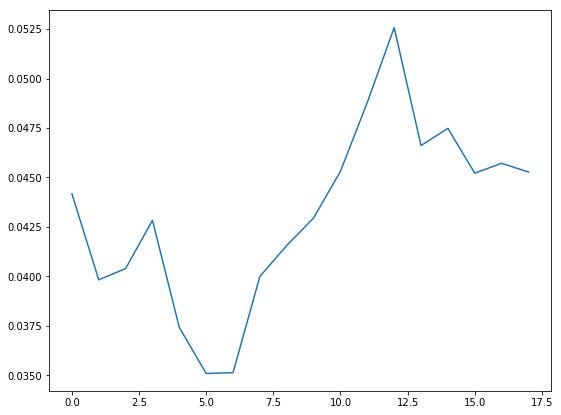

In [32]:
plot_specific_topic('refugee')